# Imports

In [1]:
import torch
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import json
import os
from tqdm import tqdm

# Dataset

## Create Data

In [2]:
################################## For sample Data ##################################
def get_rays(datapath, mode="train"):

    pose_file_names = [
        f for f in os.listdir(datapath + f"/{mode}/pose") if f.endswith(".txt")
    ]
    intrisics_file_names = [
        f for f in os.listdir(datapath + f"/{mode}/intrinsics") if f.endswith(".txt")
    ]
    img_file_names = [f for f in os.listdir(datapath + "/imgs") if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f"/{mode}/pose/" + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f"/{mode}/intrinsics/" + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + "/imgs/" + name.replace("txt", "png")) / 255.0
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4:  # RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H * W, 3))
    rays_d = np.zeros((N, H * W, 3))
    target_px_values = images.reshape((N, H * W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), -np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values


In [4]:
a,b,c = get_rays('./data_raw/fox')

/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_44577/4039139909.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + "/imgs/" + name.replace("txt", "png")) / 255.0


In [10]:
################################## ns-process-data output ##################################

def get_rays(datapath):
    f = open(datapath)
    data = json.load(f)

    N = len(np.array(data["frames"]))

    # Make array for poses (placeholder)
    poses = np.zeros((N, 4, 4))

    # Make intrinsics array
    intrinsics = np.zeros((N, 4, 4))
    intrinsics[:, 0, 0] = data["fl_x"]
    intrinsics[:, 0, 2] = data["cx"]
    intrinsics[:, 1, 1] = data["fl_y"]
    intrinsics[:, 1, 2] = data["cy"]
    intrinsics[:, 2, 2] = 1
    intrinsics[:, 3, 3] = 1

    # Make images array
    images = []

    #! Temporary 10 images
    for i in tqdm(range(N), desc="Loading Images...", colour="red"):
        pose = np.array(data["frames"][i]["transform_matrix"], dtype=float)
        poses[i] = pose

        img = (
            imageio.imread(f"./ns_opt_res_ferrari/{data['frames'][i]['file_path']}")
            / 255.0
        )
        images.append(img[None, ...])

    print("Running concatenation...")
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    # For tranparent images
    if images.shape[3] == 4:  # RGBA ->  RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1])

    # Ray Origins
    rays_o = np.zeros((N, H * W, 3))
    # Ray Directions
    rays_d = np.zeros((N, H * W, 3))
    # Image target
    target_px_values = images.reshape((N, H * W, 3))

    for i in tqdm(range(N), desc="Generating rays...", colour="green"):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), -np.ones_like(u) * f), axis=-1)

        # Accounting for theta (camera angle)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

In [11]:
a,b,c = get_rays("../data_raw/ns_opt_res_ferrari/")

Loading Images...:   0%|          | 0/223 [00:00<?, ?it/s]/var/folders/76/8q2f8pb568911qbxyw16cpxw0000gn/T/ipykernel_25856/2015895753.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(f"./ns_opt_res_ferrari/{data['frames'][i]['file_path']}")
Loading Images...: 100%|██████████| 223/223 [00:01<00:00, 201.48it/s]


Running concatenation...


Generating rays...: 100%|██████████| 223/223 [00:04<00:00, 48.26it/s]


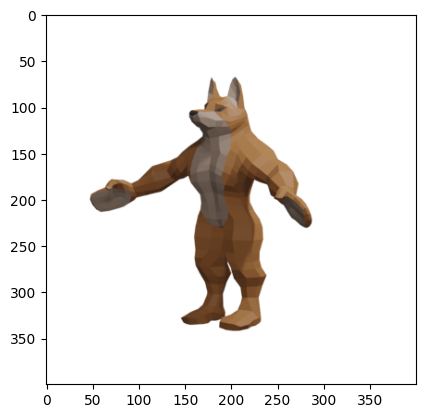

In [9]:
# Fox data: 400x400
# Ferrari data: 960x540
# HxW format
plt.imshow(c[3].reshape(400, 400, 3)[:, :, :3])

## Create Loader

### Live Processing

In [10]:
flat_data = torch.cat((torch.from_numpy(a).reshape(-1, 3),
                                   torch.from_numpy(b).reshape(-1, 3),
                                   torch.from_numpy(c).reshape(-1, 3)), dim=1).float() #? -> [n, [ray_o_x, ray_o_y, ray_o_z, ray_d_x, ray_d_y, ray_d_z, px_r, px_g, px_b]]

In [11]:
print(a.shape)
print(b.shape)
print(c.shape)

(90, 160000, 3)
(90, 160000, 3)
(90, 160000, 3)


In [12]:
dataloader = DataLoader(flat_data, batch_size=1000)

### Load Processed Data

In [21]:
load_data = np.load('./ferrari.npy')
dataloader = DataLoader(torch.from_numpy(load_data), batch_size=1200)

In [22]:
load_data.shape

array([[ 3.9522374 ,  0.17581683, -0.13746329, ...,  0.54509807,
         0.34901962,  0.21960784],
       [ 3.9522374 ,  0.17581683, -0.13746329, ...,  0.54509807,
         0.34901962,  0.21960784],
       [ 3.9522374 ,  0.17581683, -0.13746329, ...,  0.54901963,
         0.3529412 ,  0.22352941],
       ...,
       [ 3.8292801 , -0.55503815, -1.0296626 , ...,  0.8392157 ,
         0.8509804 ,  0.87058824],
       [ 3.8292801 , -0.55503815, -1.0296626 , ...,  0.84313726,
         0.85490197,  0.8745098 ],
       [ 3.8292801 , -0.55503815, -1.0296626 , ...,  0.84313726,
         0.85490197,  0.8745098 ]], dtype=float32)

# K-Planes Implementation

In [17]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


def to_cartesian(theta_phi):
    return torch.stack(
        [
            torch.sin(theta_phi[:, 0]) * torch.cos(theta_phi[:, 1]),
            torch.sin(theta_phi[:, 0]) * torch.sin(theta_phi[:, 1]),
            torch.cos(theta_phi[:, 0]),
        ],
        axis=1,
    )


class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=20, embedding_dim_direction=8, hidden_dim=128):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 3 + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim + 1),
        )

        self.block3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.Linear(hidden_dim // 2, 75),
        )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

        self.bandwidth = nn.Parameter(torch.zeros((1, 25)))
        self.p = nn.Parameter(torch.randn((25, 2)))

    @staticmethod
    def positional_encoding(x, L):
        out = torch.empty(x.shape[0], x.shape[1] * 2 * L, device=x.device)
        for i in range(x.shape[1]):
            for j in range(L):
                out[:, i * (2 * L) + 2 * j] = torch.sin(2**j * x[:, i])
                out[:, i * (2 * L) + 2 * j + 1] = torch.cos(2**j * x[:, i])
        return out

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos // 2)
        h = self.block1(emb_x)
        tmp = self.block2(torch.cat((h, emb_x), dim=1))
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1])
        h = self.block3(h)
        k = self.block4(h).reshape(o.shape[0], 25, 3)

        c = (
            k
            * torch.exp(
                (
                    self.bandwidth.unsqueeze(-1)
                    * to_cartesian(self.p).unsqueeze(0)
                    * d.unsqueeze(1)
                )
            )
        ).sum(1)

        return torch.sigmoid(c), sigma


@torch.no_grad()
def test(hn, hf, dataset, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):
    ray_origins = dataset[img_index * H * W : (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W : (img_index + 1) * H * W, 3:6]

    data = []
    for i in tqdm(range(int(np.ceil(H / chunk_size)))):
        ray_origins_ = ray_origins[i * W * chunk_size : (i + 1) * W * chunk_size].to(
            device
        )
        ray_directions_ = ray_directions[
            i * W * chunk_size : (i + 1) * W * chunk_size
        ].to(device)
        regenerated_px_values = render_rays(
            model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins
        )
        data.append(regenerated_px_values)

    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)
    plt.figure()
    plt.imshow(img)
    plt.savefig(f"{img_index}.png", bbox_inches="tight")
    plt.close()


def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat(
        (
            torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
            accumulated_transmittance[:, :-1],
        ),
        dim=-1,
    )


def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(
        ray_origins.shape[0], nb_bins
    )
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.0
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat(
        (
            t[:, 1:] - t[:, :-1],
            torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1),
        ),
        -1,
    )

    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(
        1
    )  # [batch_size, nb_bins, 3]
    ray_directions = ray_directions.expand(
        nb_bins, ray_directions.shape[0], 3
    ).transpose(0, 1)

    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    colors = colors.reshape(x.shape)
    sigma = sigma.reshape(x.shape[:-1])

    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(
        2
    ) * alpha.unsqueeze(2)
    c = (weights * colors).sum(dim=1)  # Pixel values
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)


def train(
    nerf_model,
    optimizer,
    scheduler,
    data_loader,
    device="cpu",
    hn=0,
    hf=1,
    nb_epochs=int(1e5),
    nb_bins=192,
):
    img_size = 960 * 540
    training_loss = []
    pre_img = []
    acc_rays = 0
    for _ in range(nb_epochs):
        for batch in tqdm(data_loader):
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)

            regenerated_px_values = render_rays(
                nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins
            )
            
            if acc_rays < img_size:
                pre_img.append(regenerated_px_values)
                acc_rays += regenerated_px_values.shape[0]
            
            else:
                pre_img = torch.cat(pre_img).detach().cpu().numpy().reshape(540,960,3)
                print(pre_img.mean())
                plt.imshow(pre_img)
                plt.title(f'{batch.mean()}')
                plt.show()
                
                pre_img = []
                acc_rays = 0
            # MSE
            
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
        scheduler.step()
        torch.save(nerf_model.cpu(), "nerf_model_plex")
        nerf_model.to(device)

    return training_loss

In [ ]:
if __name__ == "__main__":
    device = "mps"
    # training_dataset = torch.from_numpy(
    #     np.load("./training_data_.pkl", allow_pickle=True)
    # )

    # testing_dataset = torch.from_numpy(np.load("./testing_data.pkl", allow_pickle=True))
    model = NerfModel(hidden_dim=256).to(device)
    # model = torch.load("./nerf_model_plex", map_location=torch.device("mps"))
    model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        model_optimizer, milestones=[2, 4, 8], gamma=0.5
    )

    data_loader = dataloader
    # data_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)
    ac = train(
        model,
        model_optimizer,
        scheduler,
        data_loader,
        nb_epochs=14,
        device=device,
        hn=8,
        hf=12,
        nb_bins=100,
    )

    # for img_index in range(200):
    #     test(8, 12, dataloader, img_index=img_index, nb_bins=100, H=400, W=400)


In [ ]:
plt.imshow(torch.cat(ac).detach().cpu().numpy().reshape(400,400,3))

### NeRF

In [15]:
import torch
import torch.nn as nn


class Voxels(nn.Module):

    def __init__(self, nb_voxels=100, scale=1, device="cpu"):
        super(Voxels, self).__init__()

        self.voxels = torch.nn.Parameter(
            torch.rand(
                (nb_voxels, nb_voxels, nb_voxels, 4), device=device, requires_grad=True
            )
        )

        self.nb_voxels = nb_voxels
        self.device = device
        self.scale = scale

    def forward(self, xyz, d):

        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]

        cond = (
            (x.abs() < (self.scale / 2))
            & (y.abs() < (self.scale / 2))
            & (z.abs() < (self.scale / 2))
        )

        indx = (x[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(
            torch.long
        )
        indy = (y[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(
            torch.long
        )
        indz = (z[cond] / (self.scale / self.nb_voxels) + self.nb_voxels / 2).type(
            torch.long
        )

        colors_and_densities = torch.zeros((xyz.shape[0], 4), device=xyz.device)
        colors_and_densities[cond, :3] = self.voxels[indx, indy, indz, :3]
        colors_and_densities[cond, -1] = self.voxels[indx, indy, indz, -1]

        return torch.sigmoid(colors_and_densities[:, :3]), torch.relu(
            colors_and_densities[:, -1:]
        )

    def intersect(self, x, d):
        return self.forward(x, d)


class Nerf(nn.Module):

    def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
        super(Nerf, self).__init__()

        self.block1 = nn.Sequential(
            nn.Linear(Lpos * 6 + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim + Lpos * 6 + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim + 1),
        )

        self.rgb_head = nn.Sequential(
            nn.Linear(hidden_dim + Ldir * 6 + 3, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3),
            nn.Sigmoid(),
        )

        self.Lpos = Lpos
        self.Ldir = Ldir

    def positional_encoding(self, x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2**j * x))
            out.append(torch.cos(2**j * x))
        return torch.cat(out, dim=1)

    def forward(self, xyz, d):

        x_emb = self.positional_encoding(xyz, self.Lpos)  # [batch_size, Lpos * 6 + 3]
        d_emb = self.positional_encoding(d, self.Ldir)  # [batch_size, Ldir * 6 + 3]

        h = self.block1(x_emb)  # [batch_size, hidden_dim]
        h = self.block2(torch.cat((h, x_emb), dim=1))  # [batch_size, hidden_dim + 1]
        sigma = h[:, -1]
        h = h[:, :-1]  # [batch_size, hidden_dim]
        c = self.rgb_head(torch.cat((h, d_emb), dim=1))

        return c, torch.relu(sigma)

    def intersect(self, x, d):
        return self.forward(x, d)


# Rendering

## Prepare Input Rays

In [41]:
H = W = 400
idx = 4

o = flat_data[idx*H*W:(idx+1)*H*W, :3].float() # 1 img -> [i: i+H*W, :3]
d = flat_data[idx*H*W:(idx+1)*H*W, 3:6].float() # 1 img -> [i: i+H*W, 3:6]

target = flat_data[idx*H*W:(idx+1)*H*W, 6:].float()

model = torch.load('../Nerf_testing/NeRF_100/nerf_model_fox', map_location='mps')

o.shape

torch.Size([160000, 3])

In [50]:
# Target Image
target_img = target.reshape(400, 400, 3)
target_img = target_img.detach().cpu().numpy()

## Generate Output

100%|██████████| 20/20 [00:12<00:00,  1.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


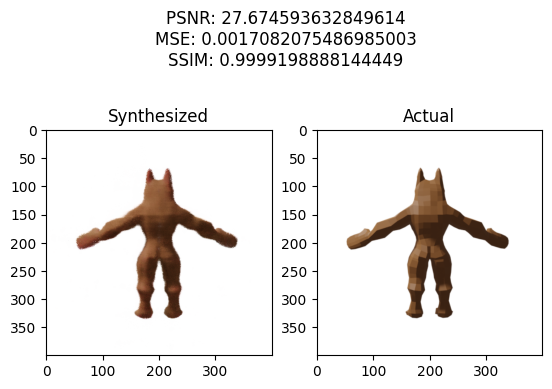

In [73]:
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity
from skimage.color import rgb2gray

chunk_size = 20 # Rendering part by part
device = torch.device('mps')
img_reg = []

#! IMPORTANT
with torch.no_grad():
    for i in tqdm(range(int(np.ceil(400 / chunk_size)))):
        ray_origins_ = o[i * 400 * chunk_size : (i + 1) * 400 * chunk_size].to(device)
        ray_directions_ = d[i * 400 * chunk_size : (i + 1) * 400 * chunk_size].to(device)
        
        regenerated_px_values = render_rays(
            model, ray_origins_, ray_directions_, hn=8, hf=12, nb_bins=100
        )
        
        img_reg.append(regenerated_px_values)

img = torch.cat(img_reg).data.cpu().numpy().reshape(400, 400, 3)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Synthesized")
ax[1].imshow(target_img)
ax[1].set_title("Actual")

psnr = peak_signal_noise_ratio(target_img, img)
mse = mean_squared_error(target_img, img)
ssim = structural_similarity(rgb2gray(target_img), rgb2gray(img), data_range=255)

fig.suptitle(f"PSNR: {psnr}\nMSE: {mse}\nSSIM: {ssim}")

In [71]:
psnr = peak_signal_noise_ratio(target_img, img)
mse = mean_squared_error(target_img, img)
ssim = structural_similarity(rgb2gray(target_img), rgb2gray(img), data_range=255)

print(f"PSNR: {psnr}")
print(f"MSE: {mse}")
print(f"SSIM: {ssim}")

PSNR: 27.71269242682877
MSE: 0.0016932877141683966
SSIM: 0.9999203302568818


# Mesh Extraction

In Progress...

In [8]:
import mcubes
import trimesh
from backbones.nerf import NerfModel

In [9]:
device = 'mps'
hn = 8.
hf = 12.
model = torch.load('./models/nerf_model_plex_6.pth').to(device)

In [10]:
N = 100
scale = 2

x = torch.linspace(-scale, scale, N)
y = torch.linspace(-scale, scale, N)
z = torch.linspace(-scale, scale, N)

x, y, z = torch.meshgrid((x, y, z))

/Users/vansh/anaconda3/envs/main-ai/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448804225/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
xyz = torch.cat((x.reshape(-1, 1),
                 y.reshape(-1, 1),
                 z.reshape(-1, 1)), dim=1)

In [12]:
with torch.no_grad():
    _, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))
    
density = density.cpu().numpy().reshape(N, N, N)

In [13]:
_, density = model.forward(xyz.to(device), torch.zeros_like(xyz).to(device))

In [ ]:
vertices, triangles = mcubes.marching_cubes(density, 30 * np.mean(density))

In [7]:
data = np.load('./data/training_data_.pkl', allow_pickle=True)

In [13]:
data.shape

(16000000, 9)

In [14]:
plt.imshow(data.reshape(90, 400, 400, 3)[:, :, :3])

ValueError: cannot reshape array of size 144000000 into shape (90,400,400,3)